### Benefits of using feature selection

[Original author](https://inria.github.io/scikit-learn-mooc/python_scripts/feature_selection_introduction.html).
Under a CC-BY License by Inria Learning Lab, scikit-learn @ La Fondation Inria, Inria Academy.


In this notebook, we aim at introducing the main benefits that can be gained when using feature selection.

Indeed, the principal advantage of selecting features within a machine learning pipeline is to reduce the time to train this pipeline and its time to predict. We will give an example to highlights these advantages. First, we generate a synthetic dataset to control the number of features that will be informative, redundant, repeated, and random.

The code snippet you provided generates a synthetic classification dataset using scikit-learn's make_classification function.

In [1]:
from sklearn.datasets import make_classification

data, target = make_classification(
    n_samples=5000,
    n_features=100,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    random_state=0,
)

Here's what each parameter means:

-  n_samples: The total number of samples in the dataset. In this case, there are 5000 samples.  
- n_features: The total number of features for each sample. In this case, each sample has 100 features.  
- n_informative: The number of informative features. These are the features that contribute to the target variable and are used to create a separation between classes. In this case, there are 2 informative features.  
- n_redundant: The number of redundant features. These are randomly generated linear combinations of informative features. In this case, there are 0 redundant features.  
- n_repeated: The number of duplicated features. These are randomly duplicated informative features. In this case, there are 0 duplicated features.  
- random_state: A seed for the random number generator, ensuring that if you run this code with the same seed, you'll get the same synthetic dataset. This is useful for reproducibility.  
  
The function returns two arrays:

- data: A 2D NumPy array containing the feature values for each sample.  
- target: A 1D NumPy array containing the binary class labels (0 or 1) for each sample.


We choose to create a dataset with two informative features among a hundred. To simplify our example, we do not include either redundant or repeated features.

We will create two machine learning pipelines. The former will be a random forest that will use all available features. The latter will also be a random forest, but we will add a feature selection step to train this classifier. The feature selection is based on a univariate test (ANOVA F-value) between each feature and the target that we want to predict. The features with the two most significant scores are selected.

Let’s create the model without any feature selection:

In Google Colab, the available resources, including the number of CPU cores, can vary.   
You can check the number of available CPU cores in your Colab runtime by running the following command:

In [2]:
import os
print(os.cpu_count())

2


The n_jobs parameter in scikit-learn is used to specify the number of parallel jobs to run during training and prediction.

In [3]:
from sklearn.ensemble import RandomForestClassifier

model_without_selection = RandomForestClassifier(n_jobs=2)

Then, let’s create a pipeline where the first stage will make the feature selection processing.

SelectKBest for Feature Selection:  
SelectKBest is a feature selection method in scikit-learn.  
- score_func=f_classif specifies that the ANOVA F-statistic will be used as the scoring function. This function assesses the linear dependency between a feature and the target variable for classification tasks.  
- k=2 indicates that you want to select the top 2 features based on the F-statistic scores.

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline


model_with_selection = make_pipeline(
    SelectKBest(score_func=f_classif, k=2),
    RandomForestClassifier(n_jobs=2),
)

We will measure the average time spent to train each pipeline and make it predict. Besides, we will compute the testing score of the model. We will collect these results via cross-validation.

Let’s start with the random forest without feature selection. We will store the results into a dataframe.

In [5]:
import pandas as pd
from sklearn.model_selection import cross_validate

cv_results_without_selection = cross_validate(
    model_without_selection, data, target
)
cv_results_without_selection = pd.DataFrame(cv_results_without_selection)

Now, we will repeat the process for the pipeline incorporating the feature selection.

In [6]:
cv_results_with_selection = cross_validate(
    model_with_selection, data, target, return_estimator=True
)
cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

To analyze the results, we will merge the results from the two pipeline in a single pandas dataframe.

In [7]:
cv_results = pd.concat(
    [cv_results_without_selection, cv_results_with_selection],
    axis=1,
    keys=["Without feature selection", "With feature selection"],
)
# swap the level of the multi-index of the columns
cv_results = cv_results.swaplevel(axis="columns")

Let’s first analyze the train and score time for each pipeline.

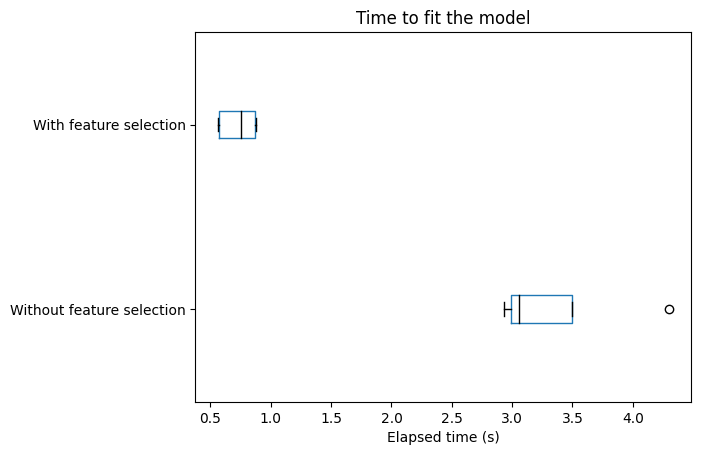

In [8]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
cv_results["fit_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to fit the model")

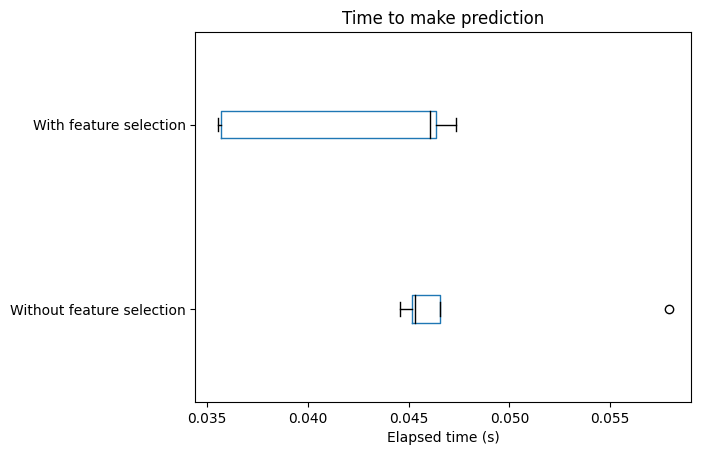

In [9]:
cv_results["score_time"].plot.box(color=color, vert=False)
plt.xlabel("Elapsed time (s)")
_ = plt.title("Time to make prediction")

We can draw the same conclusions for both training and scoring elapsed time: selecting the most informative features speed-up our pipeline.

Of course, such speed-up is beneficial only if the generalization performance in terms of metrics remain the same. Let’s check the testing score.

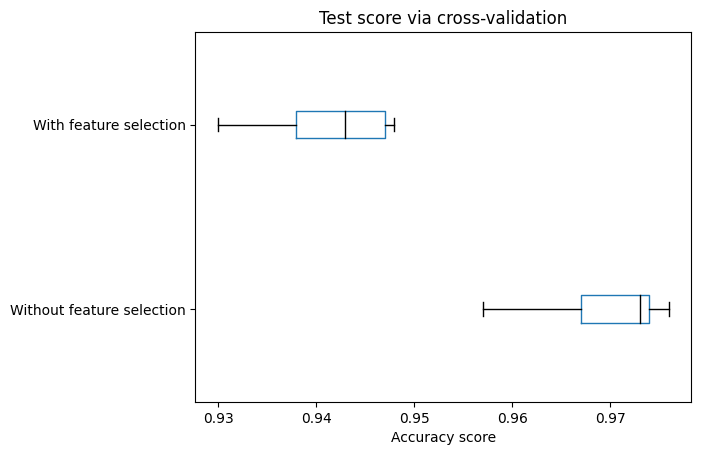

In [10]:
cv_results["test_score"].plot.box(color=color, vert=False)
plt.xlabel("Accuracy score")
_ = plt.title("Test score via cross-validation")

We can observe that the model’s generalization performance selecting a subset of features decreases compared with the model using all available features. Since we generated the dataset, we can infer that the decrease is because of the selection. The feature selection algorithm did not choose the two informative features.

We can investigate which feature have been selected during the cross-validation. We will print the indices of the two selected features.

In [11]:
import numpy as np

for idx, pipeline in enumerate(cv_results_with_selection["estimator"]):
    print(
        f"Fold #{idx} - features selected are: "
        f"{np.argsort(pipeline[0].scores_)[-2:]}"
    )

Fold #0 - features selected are: [89 53]
Fold #1 - features selected are: [29 53]
Fold #2 - features selected are: [52 53]
Fold #3 - features selected are: [49 53]
Fold #4 - features selected are: [49 53]


We see that the feature 53 is always selected while the other feature varies depending on the cross-validation fold.

If we would like to keep our score with similar generalization performance, we could choose another metric to perform the test or select more features. For instance, we could select the number of features based on a specific percentile of the highest scores. Besides, we should keep in mind that we simplify our problem by having informative and not informative features. Correlation between features makes the problem of feature selection even harder.